<a href="https://colab.research.google.com/github/T-Schwab/QM2/blob/main/DiD_Dams_South_Africa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install linearmodels
import pandas as pd
import seaborn as sns
import numpy as np
import plotly
import plotly.express as px
import warnings
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
sns.set(font_scale=1.5)
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
df = pd.read_csv("Subnational Unit-Data DiD South Africa.csv")

print(df.head())

  ISO3 National Unit        Name Admin Level          Metric  \
0  SWZ      Eswatini  Shiselweni      admin1  Incidence Rate   
1  SWZ      Eswatini  Shiselweni      admin1  Incidence Rate   
2  SWZ      Eswatini  Shiselweni      admin1  Incidence Rate   
3  SWZ      Eswatini  Shiselweni      admin1  Incidence Rate   
4  SWZ      Eswatini  Shiselweni      admin1  Incidence Rate   

                Units  Year     Value  
0  Cases per Thousand  2010  1.294336  
1  Cases per Thousand  2011  1.018051  
2  Cases per Thousand  2012  0.942140  
3  Cases per Thousand  2013  1.996239  
4  Cases per Thousand  2014  0.917405  


MPUMALANGA (treatment group) AND HHOHHO (control group).

In [3]:
did=df[df['Name'].isin(['Mpumalanga', 'Hhohho'])] # subset the data to only include Mpumalanga and Hhohho

px.line(did, x='Year', y='Value', color='Name', title="Malaria Incidence Rates in Mpumalanga and Hhohho") # plot the minimum wage over time

In [4]:
did['post']=np.where(did['Year']>=2016,1,0) # create a variable that is 1 if the date is after the dam construction and 0 otherwise
did['treatment']=np.where(did['Name']=='Mpumalanga',1,0) # create a variable that is 1 if the state is Mpumalanga (i.e., the treatment group) and 0 for Hhohho (the control group)
did['post_treatment']=did['post']*did['treatment'] # create a variable that is 1 if the date is after dam construction and the state is Mpumalanga and 0 otherwise

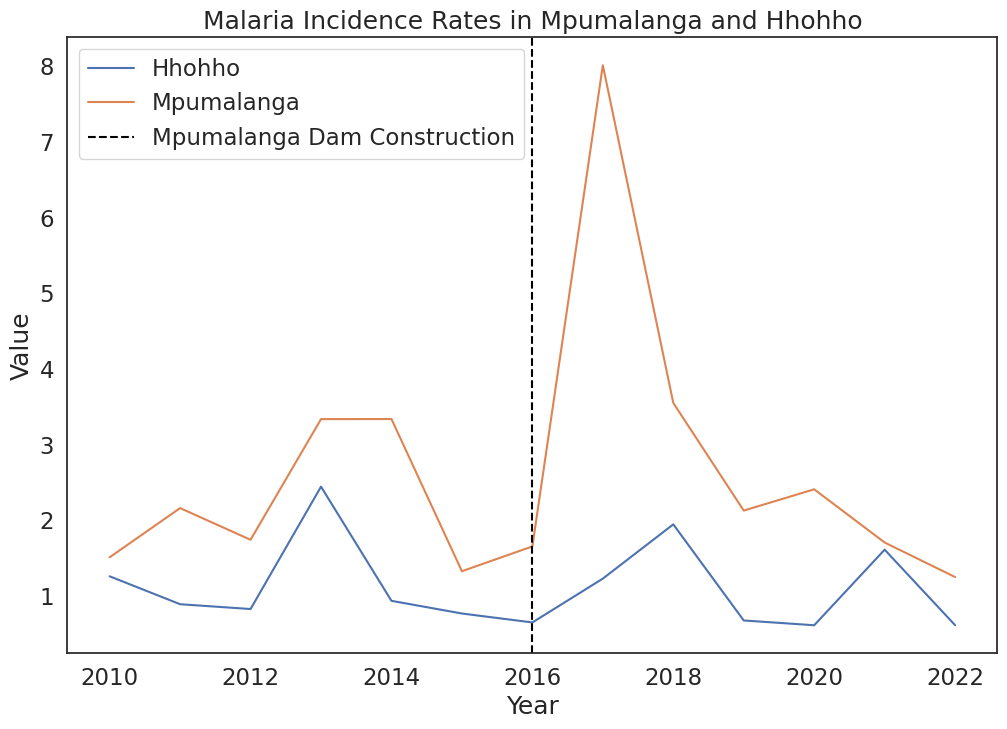

In [5]:
did = did[(did['Year'] >= 2010) & (did['Year'] <= 2022)] # Filter the dataset to include years between 2010 and 2022
sns.lineplot(data=did, x='Year', y='Value', hue='Name')
plt.axvline(2016, color='black', linestyle='dashed', label='Mpumalanga Dam Construction')
plt.title('Malaria Incidence Rates in Mpumalanga and Hhohho')
plt.legend()
plt.show()


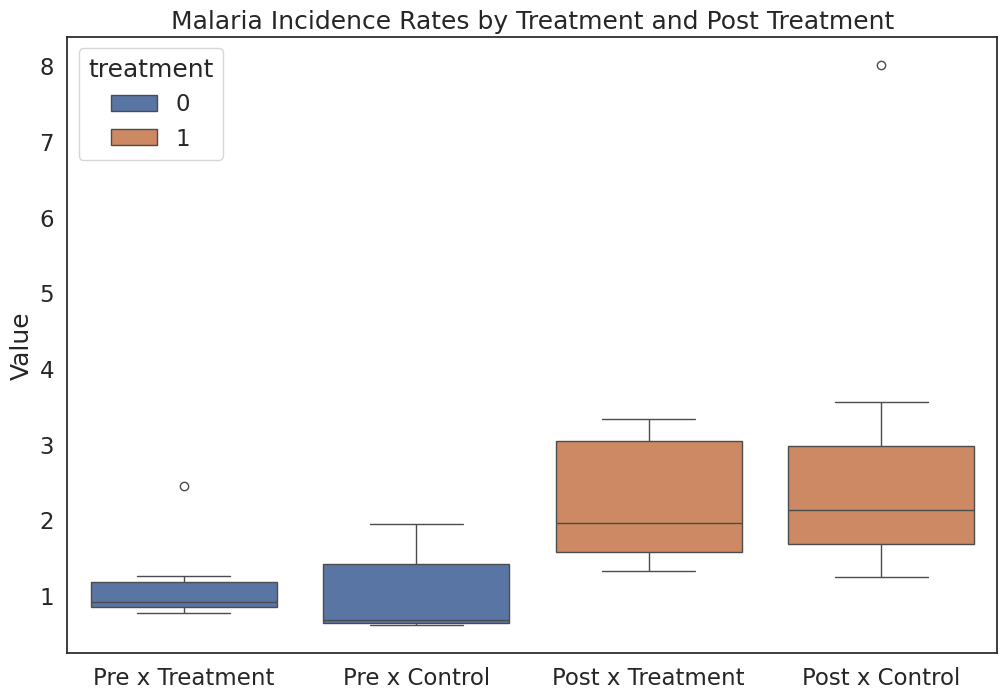

In [6]:
did['category']=did['treatment'].astype(str)+did['post'].astype(str) # this variable is just for the plot below
sns.boxplot(x='category', y='Value', hue='treatment', data=did).set_xticklabels(["Pre x Treatment", "Pre x Control",'Post x Treatment','Post x Control'])
plt.xlabel('')
plt.title('Malaria Incidence Rates by Treatment and Post Treatment')
plt.show()

In [7]:
did_model = ols('Value ~  post + treatment + post_treatment', did).fit()
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     2.974
Date:                Sun, 05 Jan 2025   Prob (F-statistic):             0.0538
Time:                        18:36:05   Log-Likelihood:                -42.824
No. Observations:                  26   AIC:                             93.65
Df Residuals:                      22   BIC:                             98.68
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.1842      0.558      2.

In [8]:
models=[] # create empty list to store the models
names=[] # create empty list to store the names of the models

for window in range(1,6): # loop through years from 2000 to 2020 in increments of 4
    did=df[(df['Year']>=(2016-window)) & (df['Year']<=(2016+window)) & df['Name'].isin(['Mpumalanga', 'Hhohho'])] # subset the data within the window of interest around 2014
    did['post']=np.where(did['Year']>=2016,1,0) # create a dummy variable indicating the period after the minimum wage increase
    did['treatment']=np.where(did['Name']=='Mpumalanga',1,0) # create a dummy variable for treatment
    did['post_treatment']=did['post']*did['treatment'] # create an interaction term between the post and treatment variables
    did_model = ols('Value ~ post + treatment + post_treatment', did).fit() # run the difference in difference model

    models.append(did_model) # append the model to the list of models
    names.append('± '+str(window)+' Year') # append the name of the model to the list of names

table=summary_col( # create a regression table
    models, # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=names, # set the names of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table) # print the table


               ± 1 Year ± 2 Year ± 3 Year ± 4 Year ± 5 Year
-----------------------------------------------------------
Intercept      0.764    0.848    1.379    1.240    1.170*  
               (3.194)  (1.421)  (1.013)  (0.773)  (0.639) 
post           0.172    0.423    -0.258   -0.221   -0.052  
               (3.912)  (1.834)  (1.339)  (1.037)  (0.865) 
treatment      0.559    1.481    1.285    1.193    1.209   
               (4.518)  (2.009)  (1.432)  (1.093)  (0.904) 
post_treatment 3.338    1.652    1.428    1.337    0.916   
               (5.533)  (2.594)  (1.894)  (1.467)  (1.224) 
R-squared      0.493    0.460    0.368    0.371    0.330   
R-squared Adj. -0.267   0.191    0.179    0.236    0.218   
N              6        10       14       18       22      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


KwaZulu-Natal (treatment group) and Shiselweni (control group).

In [9]:
did2=df[df['Name'].isin(['KwaZulu-Natal', 'Shiselweni'])] # subset the data to only include Mpumalanga and Hhohho

px.line(did2, x='Year', y='Value', color='Name', title="Malaria Incidence Rates in KwaZulu-Natal and Shiselweni") # plot the minimum wage over time

In [10]:
did2['post']=np.where(did2['Year']>=2016,1,0) # create a variable that is 1 if the date is after the dam construction and 0 otherwise
did2['treatment']=np.where(did2['Name']=='KwaZulu-Natal',1,0) # create a variable that is 1 if the state is Mpumalanga (i.e., the treatment group) and 0 for Hhohho (the control group)
did2['post_treatment']=did2['post']*did2['treatment'] # create a variable that is 1 if the date is after dam construction and the state is Mpumalanga and 0 otherwise

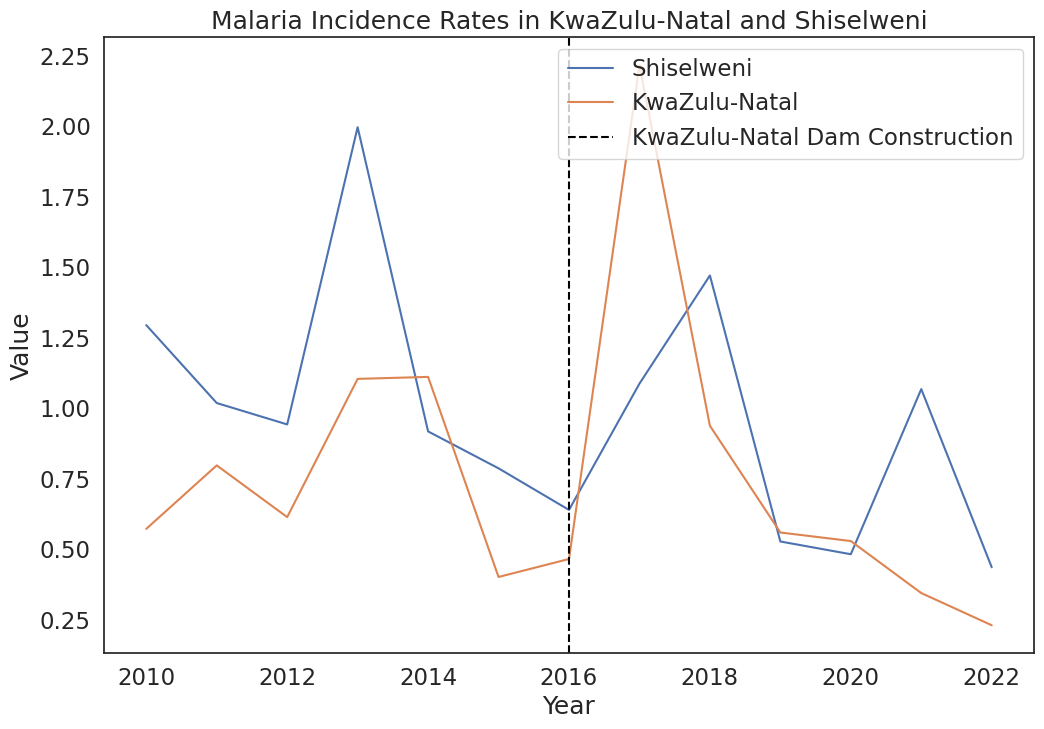

In [11]:
did2 = did2[(did2['Year'] >= 2010) & (did2['Year'] <= 2022)] # Filter the dataset to include years between 2010 and 2022
sns.lineplot(data=did2, x='Year', y='Value', hue='Name')
plt.axvline(2016, color='black', linestyle='dashed', label='KwaZulu-Natal Dam Construction')
plt.title('Malaria Incidence Rates in KwaZulu-Natal and Shiselweni')
plt.legend()
plt.show()

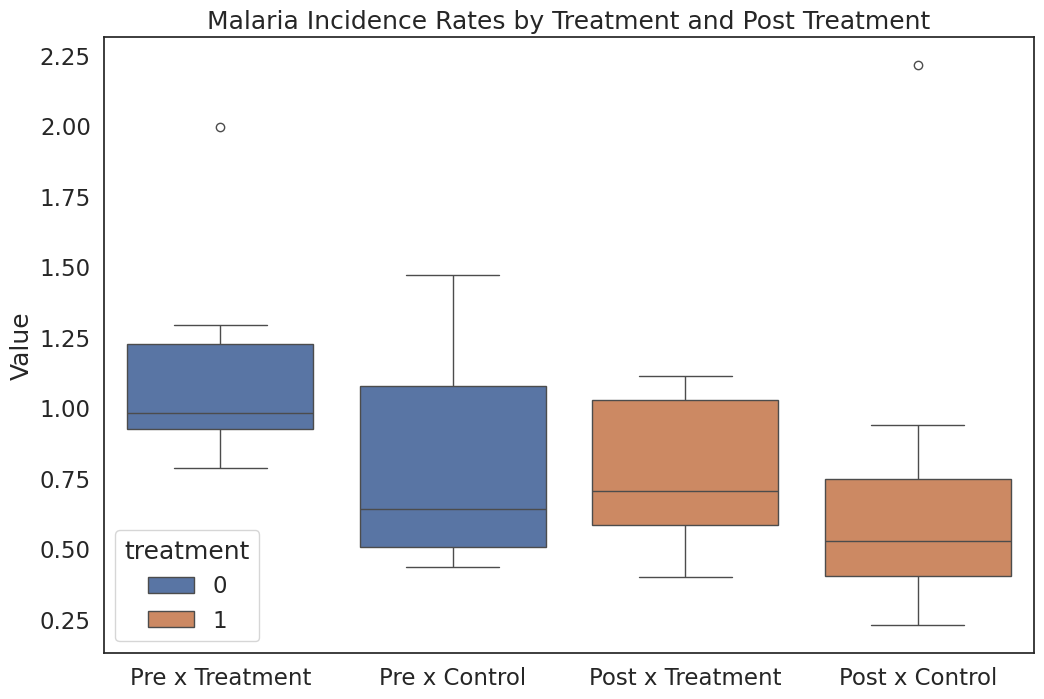

In [12]:
did2['category']=did2['treatment'].astype(str)+did2['post'].astype(str) # this variable is just for the plot below
sns.boxplot(x='category', y='Value', hue='treatment', data=did2).set_xticklabels(["Pre x Treatment", "Pre x Control",'Post x Treatment','Post x Control'])
plt.xlabel('')
plt.title('Malaria Incidence Rates by Treatment and Post Treatment')
plt.show()

In [13]:
did2_model = ols('Value ~  post + treatment + post_treatment', did2).fit()
print(did2_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9720
Date:                Sun, 05 Jan 2025   Prob (F-statistic):              0.424
Time:                        18:36:06   Log-Likelihood:                -15.803
No. Observations:                  26   AIC:                             39.61
Df Residuals:                      22   BIC:                             44.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.1591      0.197      5.

In [25]:
models=[] # create empty list to store the models
names=[] # create empty list to store the names of the models

for window in range(1,6): # loop through years from 2000 to 2020 in increments of 4
    did2=df[(df['Year']>=(2016-window)) & (df['Year']<=(2016+window)) & df['Name'].isin(['KwaZulu-Natal', 'Shiselweni'])] # subset the data within the window of interest around 2014
    did2['post']=np.where(did2['Year']>=2016,1,0) # create a dummy variable indicating the period after the minimum wage increase
    did2['treatment']=np.where(did2['Name']=='KwaZulu-Natal',1,0) # create a dummy variable for treatment
    did2['post_treatment']=did2['post']*did2['treatment'] # create an interaction term between the post and treatment variables
    did2_model = ols('Value ~ post + treatment + post_treatment', did2).fit() # run the difference in difference model

    models.append(did2_model) # append the model to the list of models
    names.append('± '+str(window)+' Year') # append the name of the model to the list of names

table=summary_col( # create a regression table
    models, # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=names, # set the names of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table) # print the table


               ± 1 Year ± 2 Year ± 3 Year ± 4 Year ± 5 Year
-----------------------------------------------------------
Intercept      0.786    0.852*   1.233*** 1.161*** 1.132***
               (0.904)  (0.433)  (0.353)  (0.275)  (0.226) 
post           0.076    0.213    -0.303   -0.320   -0.253  
               (1.107)  (0.559)  (0.467)  (0.368)  (0.305) 
treatment      -0.385   -0.096   -0.362   -0.353   -0.327  
               (1.278)  (0.612)  (0.499)  (0.388)  (0.319) 
post_treatment 0.863    0.237    0.475    0.453    0.290   
               (1.565)  (0.790)  (0.660)  (0.521)  (0.432) 
R-squared      0.283    0.119    0.060    0.069    0.068   
R-squared Adj. -0.791   -0.322   -0.223   -0.130   -0.087  
N              6        10       14       18       22      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
